# Airbnb New User Booking Prediction

This exericise is a variation of the Kaggle project: __[Airbnb New User Bookings](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings)__

While the original study aims to predict the destinations for new users' bookings, this project will predict an earlier stage of the business process: if the user will book a trip or not. The dataset shows that only around 41% of the users book a trip. Airbnb makes money through commission from hosts and transaction fee from travellers when a traveller books a room. By exploring features that incentivize a user to make a reservation and successfully predict if a user will make a reservation, the company will be able to further improve its product and drive revenue.

If you are not familiar of how Airbnb works, this article will help you:) <br>
__[How Airbnb Works](https://nextjuggernaut.com/blog/airbnb-business-model-revenue-insights/)__

## __Table of Contents__

1.  [Preparation](#prep)<br>
    1.1  [Importing Libraries](#import)<br>
    1.2  [Reading in Datasets](#readin)<br>
2.  [EDA & Feature Engineering](#eda)<br>
    2.1  [Overall Sense of the Data](#overall)<br>
    2.2  [Feature Exploration & Engineering](#explore)<br>
    2.3  [Prepare Dataset for Modeling](#prepare)<br>
    2.4  [Split Test & Train Datasets](#split)<br>
3.  [Modeling](#model)<br>
    3.1  [Logistic Regression](#logreg)<br>
    3.2  [Random Forest](#rf)<br>
    3.3  [Support Vector Machine](#svc)
4.  [Exercise Highlights](#highlight)<br>
5.  [Further Improvements](#improvement)

## 1. Preparation

<a id = 'prep'></a>

### 1.1 Importing Libraries

<a id = 'import'></a>

In [1]:
# import useful packages for the analysis

# Data Analysis & Preprocessing Packages
import pandas as pd
import numpy as np
#from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning Packages
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### 1.2 Reading in Datasets

__Data Description__

Table 1: abnb_raw: _user information _

Column Name | Column Description
-------------|:--------------------------
id | user id
date_account_created | the date of account creation
timestamp_first_active | timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
date_first_booking| date of first booking
gender | user gender
age | user age
signup_method | signup method
signup_flow | the page a user came to signup up from
language | international language preference
affiliate_channel | what kind of paid marketing
affiliate_provider | where the marketing is e.g. google, craigslist, other
first_affiliate_tracked | whats the first marketing the user interacted with before the signing up
signup_app | signup app
first_device_type | first used device
first_browser | first used browser
country_destination | this is the target variable you are to predict


Table 2: sessions: _web sessions log for users_

Column Name | Column Description
-------------|:--------------------------
user_id | to be joined with the column 'id' in users table                                                       
action |
action_type |
action_detail |
device_type |
secs_elapsed |

<a id = 'readin'></a>

In [2]:
# read in datasets
abnb_raw = pd.read_csv('data/train_users_2.csv')
sessions = pd.read_csv('data/sessions.csv')

## 2. EDA & Feature Engineering

### 2.1 Getting an Overall Sense of the data

<a id = 'overall'></a>

#### 2.1.1 Sessions Dataset

The user web session log is a huge dataset with over __10M__ records. <br>
It contains user experience data of __135,484__ unique users (About half the size of the user information dataset).<br>
In order to join this table with the user information table, we will need to aggregate and transform it. 

In [3]:
sessions.sample(5)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
6754509,7htooiq6k7,impressions,view,p4,Mac Desktop,2634.0
5638038,p5ubhzwd3w,index,view,view_search_results,Windows Desktop,579.0
4881255,7zjecuo8vv,lookup,NaN,NaN,Windows Desktop,2163.0
6719138,ia67bm43f8,show,view,user_profile,iPhone,75.0
6587720,yf4qnuyrzn,reviews,data,listing_reviews,-unknown-,170.0


In [4]:
sessions.describe(include = 'all')

,user_id,action,action_type,action_detail,device_type,secs_elapsed
count,10533241,10488111,9441533,9441533,10567737,1.043171e+07
unique,135483,359,10,155,14,NaN
top,mxqbh3ykxl,show,view,view_search_results,Mac Desktop,NaN
freq,2722,2768278,3560902,1776885,3594286,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.940581e+04
std,NaN,NaN,NaN,NaN,NaN,8.888424e+04
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,2.290000e+02
50%,NaN,NaN,NaN,NaN,NaN,1.147000e+03
75%,NaN,NaN,NaN,NaN,NaN,8.444000e+03


In [5]:
# create an actions table with each action as a feature and id as observations
sessions_agg = sessions[['user_id', 'action', 'secs_elapsed']].groupby(['user_id', 'action']).sum()
actions = sessions_agg.unstack()
actions = actions.reset_index()
actions.columns = actions.columns.droplevel()
actions = actions.rename(columns = {'':'id'})
actions = actions.fillna(0)
actions.head()

action,id,10,11,12,15,about_us,accept_decline,account,acculynk_bin_check_failed,acculynk_bin_check_success,...,view,views,views_campaign,views_campaign_rules,webcam_upload,weibo_signup_referral_finish,why_host,widget,wishlists,zendesk_login_jwt
0,00023iyk9l,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0010k6l0om,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001wyh0pz8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0028jgx1x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,002qnbzfs5,301482.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
actions.describe(include = 'all')

action,id,10,11,12,15,about_us,accept_decline,account,acculynk_bin_check_failed,acculynk_bin_check_success,...,view,views,views_campaign,views_campaign_rules,webcam_upload,weibo_signup_referral_finish,why_host,widget,wishlists,zendesk_login_jwt
count,135043,1.350430e+05,1.350430e+05,1.350430e+05,1.350430e+05,1.350430e+05,135043.000000,1.350430e+05,135043.000000,135043.000000,...,1.350430e+05,135043.000000,1.350430e+05,135043.000000,1.350430e+05,135043.000000,1.350430e+05,135043.000000,135043.000000,135043.000000
unique,135043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,4rsmtjg8o2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.881525e+03,6.458478e+02,5.871317e+03,7.118859e+02,1.948171e+02,0.104878,2.694754e+03,0.030250,0.644958,...,1.144510e+03,0.851410,8.810468e+00,2.109195,6.663100e+02,7.533956,9.717282e+01,2.672512,0.260036,4.075035
std,NaN,5.343155e+04,1.877772e+04,9.234463e+04,2.175797e+04,1.033990e+04,38.540666,3.570584e+04,11.116192,67.886333,...,2.031090e+04,218.994644,3.196676e+03,725.853192,1.335305e+04,1036.731932,6.135468e+03,556.011678,95.558429,529.001710
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
75%,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


___actions_ table__

The _actions_ table contains information of how long each user spend on each action. <br>
It contains __135043__ unique users and 358 unique actions. <br>
I filled all the NaN cells with 0, assuming the user has not trigger the particular action if there is no log information associated with the user id and specific action name. <br>
To make the analysis more accurate, I will consider using dimensionality reducing techniques. However, we will the table as it is for now.

#### 2.1.2 abnb Dataset

This table contains user information of __213,178__ unique users.

In [7]:
abnb_raw.head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [8]:
abnb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


### 2.2 Feature Exploration & Engineering

<a id = 'explore'></a>

In [9]:
# Generating Target Variable
abnb_raw.loc[abnb_raw['date_first_booking'].notnull(), 'booked'] = 1
abnb_raw.loc[abnb_raw['date_first_booking'].isnull(), 'booked'] = 0

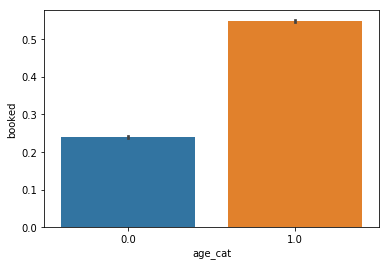

In [10]:
# age
# Half of the values for age are missing, making it very hard to impute
# for the available age values, there are some unreasonable ones: age over 100, age over 1000
# it is hard to make sense of these unresonable inputs
# therefore, modified age into a binary variable 'age_cat' where 
# 1 means a meaningful age is provided and 0 means the age provided is incorrect or age is not provided
abnb_raw.loc[(abnb_raw['age']<18) |(abnb_raw['age'] >99)|(abnb_raw['age'].isnull()), 'age_cat' ] = 0
abnb_raw.loc[(abnb_raw['age'] >=18) & (abnb_raw['age']<=99), 'age_cat'] = 1
sns.barplot(x = 'age_cat', y = 'booked', data = abnb_raw)

                    id
first_browser         
-unknown-        27266
AOL Explorer       245
Android Browser    851
Chrome           63845
Chrome Mobile     1270
Firefox          33655
IE               21068
Mobile Safari    19274
Safari           45169
other              808


Text(0.5,1,'Booking Rate by First Browser')

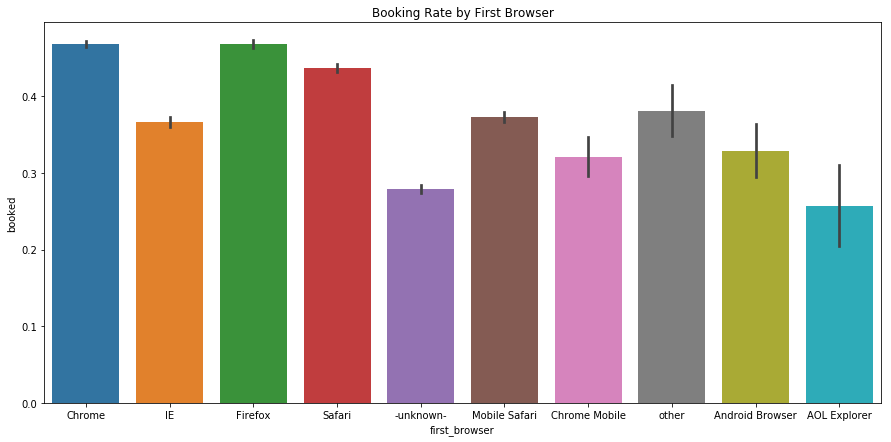

In [11]:
# first_browser
major_browser_list = ['-unknown-', 'Chrome', 'AOL Explorer', 'Android Browser', 
                      'Chrome Mobile', 'Firefox', 'IE', 'Mobile Safari',
                     'Safari']
abnb_raw.loc[~abnb_raw['first_browser'].isin(major_browser_list), 'first_browser'] = 'other'
print(abnb_raw[['id', 'first_browser']].groupby('first_browser').count())
plt.subplots(figsize = (15, 7))
sns.barplot(x = 'first_browser', y = 'booked', data = abnb_raw).set_title('Booking Rate by First Browser')

Text(0.5,1,'Booking Rate by First Device Type')

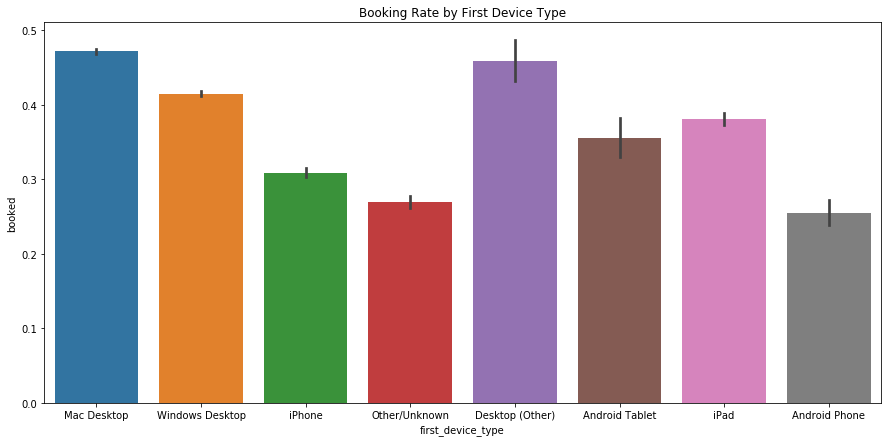

In [12]:
# first_device_type
# Combined Smartphone(other) with Other/Unknown since it's got too few observations
abnb_raw.loc[abnb_raw['first_device_type'] == 'SmartPhone (Other)', 'first_device_type'] = 'Other/Unknown'
abnb_raw[['id', 'first_device_type']].groupby('first_device_type').count()
plt.subplots(figsize = (15, 7))
sns.barplot(x = 'first_device_type', y = 'booked', data = abnb_raw).set_title('Booking Rate by First Device Type')

Text(0.5,1,'Booking Rate by Signup APP')

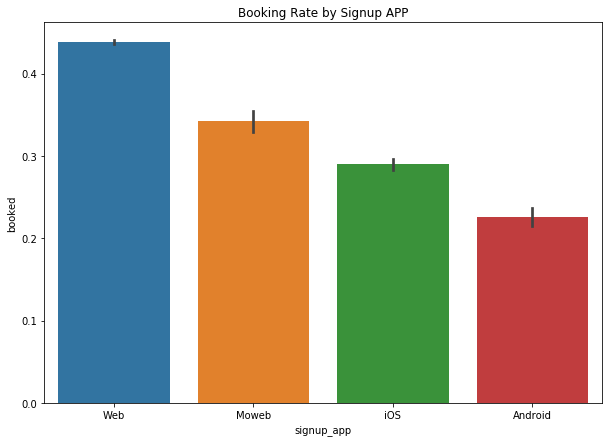

In [13]:
# signup APP
abnb_raw[['id', 'signup_app']].groupby('signup_app').count()
plt.subplots(figsize = (10, 7))
sns.barplot(x = 'signup_app', y = 'booked', data = abnb_raw).set_title('Booking Rate by Signup APP')

Text(0.5,1,'Booking Rate by Affiliate Provider')

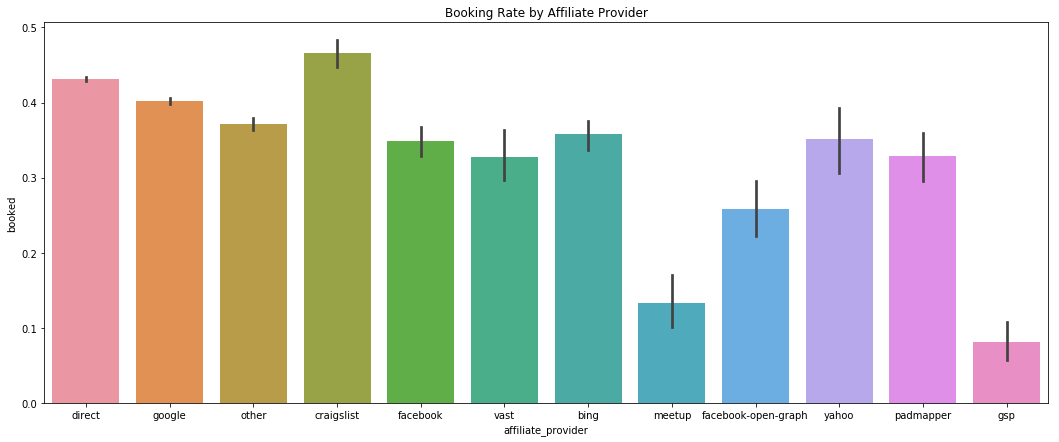

In [14]:
# affiliate_provider
# dropped the classes with too few observations (<1% of the entire dataset)
abnb_raw[['id', 'affiliate_provider']].groupby('affiliate_provider').count()
aff_provider_drop_list = ['baidu', 'daum', 'email-marketing', 'naver', 'wayn', 'yandex']
abnb_raw = abnb_raw[~abnb_raw['affiliate_provider'].isin(aff_provider_drop_list)]
plt.subplots(figsize = (18, 7))
sns.barplot(x = 'affiliate_provider', y = 'booked', data = abnb_raw).set_title('Booking Rate by Affiliate Provider')

Text(0.5,1,'Booking Rate by Affiliate Channel')

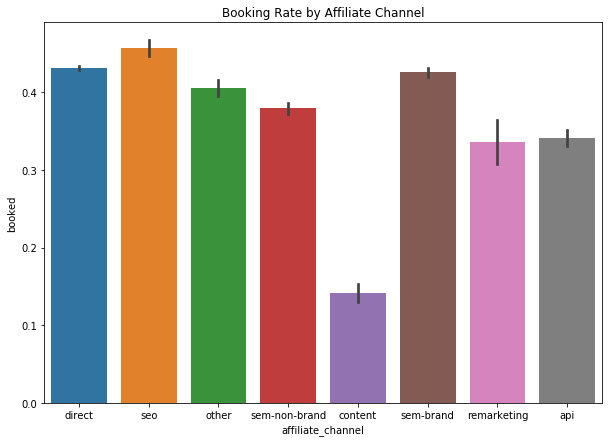

In [15]:
# affiliate channel
abnb_raw[['id','affiliate_channel']].groupby('affiliate_channel').count()
plt.subplots(figsize = (10, 7))
sns.barplot(x = 'affiliate_channel', y = 'booked', data = abnb_raw).set_title('Booking Rate by Affiliate Channel')

In [16]:
# 94% of the records have a class of 'en'
# however, running a statistical test indicates that there is a significant difference between the booking rate of English and non-English speakers
# Recategorize language into a new variable with only 2 classes: 1 for 'en'; 0 for 'non-en'
abnb_raw.loc[abnb_raw['language'] == 'en', 'language_cat'] = 1
abnb_raw.loc[abnb_raw['language'] != 'en', 'language_cat'] = 0

                 id
signup_flow        
0            164505
1              1047
2              6881
3              8822
4                 1
5                36
6               301
8               240
10                2
12             9329
15               10
16               11
20               14
21              196
23             2832
24             4323
25            14628


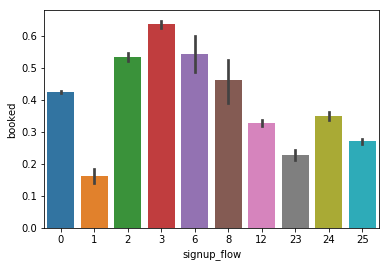

In [17]:
# signup_flow
print(abnb_raw[['id', 'signup_flow']].groupby('signup_flow').count())
# signup_flow is a categorical variable with high caridnality. 
# some of the classes only represent a small proportion of records.
# In order to make the analysis more meaningful and less subjective to extremely values, I will drop all the classes with less than 1% of the total sample size
# That is: 4, 5, 10, 15, 16, 20, 21
signup_flow_drop_list = [4,5,10, 15, 16, 20, 21]
abnb_raw = abnb_raw[~abnb_raw['signup_flow'].isin(signup_flow_drop_list)] 
sns.barplot(x = 'signup_flow', y = 'booked', data = abnb_raw)

# change numerical value to categorical
abnb_raw.loc[abnb_raw['signup_flow'] == 0, 'signup_flow'] = 'signup_flow_0'
abnb_raw.loc[abnb_raw['signup_flow'] == 1, 'signup_flow'] = 'signup_flow_1'
abnb_raw.loc[abnb_raw['signup_flow'] == 2, 'signup_flow'] = 'signup_flow_2'
abnb_raw.loc[abnb_raw['signup_flow'] == 3, 'signup_flow'] = 'signup_flow_3'
abnb_raw.loc[abnb_raw['signup_flow'] == 6, 'signup_flow'] = 'signup_flow_6'
abnb_raw.loc[abnb_raw['signup_flow'] == 8, 'signup_flow'] = 'signup_flow_8'
abnb_raw.loc[abnb_raw['signup_flow'] == 12, 'signup_flow'] = 'signup_flow_12'
abnb_raw.loc[abnb_raw['signup_flow'] == 23, 'signup_flow'] = 'signup_flow_23'
abnb_raw.loc[abnb_raw['signup_flow'] == 24, 'signup_flow'] = 'signup_flow_24'
abnb_raw.loc[abnb_raw['signup_flow'] == 25, 'signup_flow'] = 'signup_flow_25'

Text(0.5,1,'Booking Rate by Signup Method')

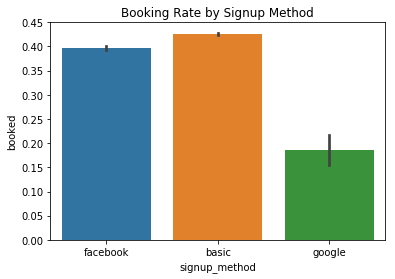

In [18]:
# signup_method
sns.barplot(x = 'signup_method', y = 'booked', data = abnb_raw).set_title('Booking Rate by Signup Method')

In [19]:
# create a variable for the time difference between first active time and date account created
# since there are only a few records that activated before creating an account, made timediff a dummy variable
# 1 means activated before account created
# 0 means activated when account created
type(abnb_raw.loc[0,'timestamp_first_active'])
type(abnb_raw.loc[0, 'date_account_created'])
abnb_raw['acct_created_dt'] = pd.to_datetime(abnb_raw['date_account_created'], infer_datetime_format = True)

abnb_raw['first_active_dt'] = abnb_raw['timestamp_first_active'].astype(str)
abnb_raw['first_active_dt'] = abnb_raw['first_active_dt'].str.slice(0, 8)
abnb_raw['first_active_dt'] = pd.to_datetime(abnb_raw['first_active_dt'], format='%Y%m%d')
abnb_raw['timediff'] = pd.to_numeric(abnb_raw['acct_created_dt'] - abnb_raw['first_active_dt'])
abnb_raw.loc[abnb_raw['timediff']!=0 , 'timediff'] = 1


id                         95527
date_account_created       95527
timestamp_first_active     95527
date_first_booking         28991
gender                     95527
age                        16819
signup_method              95527
signup_flow                95527
language                   95527
affiliate_channel          95527
affiliate_provider         95527
first_affiliate_tracked    91624
signup_app                 95527
first_device_type          95527
first_browser              95527
country_destination        95527
booked                     95527
age_cat                    95527
language_cat               95527
acct_created_dt            95527
first_active_dt            95527
timediff                   95527
dtype: int64


Text(0.5,1,'Boooking Rate for Gender Specification')

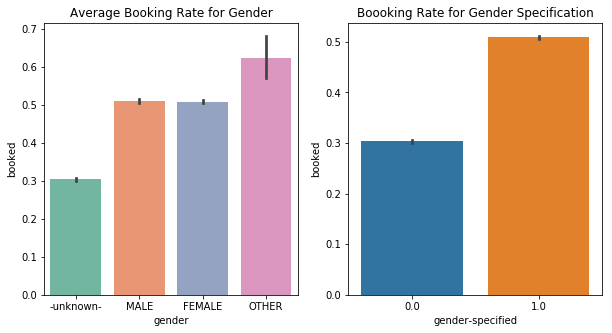

In [20]:
### Explore Gender ###

print(abnb_raw.loc[(abnb_raw['gender'] == '-unknown-') ].count())
# The average booking rate for gender plot shows that there isn't a significant difference between female and male
# Also, about half of the records have unknown gender specification, which has a substaintially lower booking rate
# Convert Gender from 4 class into binary classess
# 1 for specified gender; 0 for unknown gender
abnb_raw.loc[abnb_raw['gender'] == '-unknown-', 'gender-specified'] = 0
abnb_raw.loc[(abnb_raw['gender'] == 'MALE')|(abnb_raw['gender'] =='FEMALE')|(abnb_raw['gender'] =='OTHER'), 'gender-specified'] = 1
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10,5))
sns.barplot(x = 'gender', y='booked', data = abnb_raw, palette = 'Set2', ax = ax1).set_title('Average Booking Rate for Gender')
sns.barplot(x = 'gender-specified', y='booked', data = abnb_raw, ax = ax2).set_title('Boooking Rate for Gender Specification')

### 2.3 Preparing Datasets for Modeling

<a id = 'prepare'></a>

In [21]:
### Drop Unnecessary columns

# first_affiliate_tracked: dropped because half of the value is 'untracked', which essentially gives no information
# gender: dropped as we creates a new gender-specified column
# date_first_booking: information that will not be available for us when we predict if the user will make a booking
# country_destination: this will also not be available for us when we predict if the user will make a booking
# age: while this is likely to be an important feature, there are too many missing values and abnormal values in the dataset 

abnb = abnb_raw.drop(['first_affiliate_tracked', 'gender', 'date_first_booking', 'country_destination', 'age'], axis = 1)
# drop inter-stage variables
abnb = abnb.drop(['timestamp_first_active','date_account_created','acct_created_dt','first_active_dt'], axis = 1)
abnb = abnb.drop(['language'], axis = 1)

In [22]:
# use get dummies to change nominal features

dummies = pd.get_dummies(abnb[['signup_method', 'signup_flow', 'affiliate_channel', 'affiliate_provider',
                     'signup_app', 'first_device_type', 'first_browser']], drop_first = True)
abnb_dm = abnb.drop(['signup_method', 'signup_flow', 'affiliate_channel', 'affiliate_provider',
                     'signup_app', 'first_device_type', 'first_browser'], axis = 1)
abnb_dm = pd.concat([abnb_dm, dummies], axis = 1)
abnb_dm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212908 entries, 0 to 213450
Data columns (total 54 columns):
id                                        212908 non-null object
booked                                    212908 non-null float64
age_cat                                   212908 non-null float64
language_cat                              212908 non-null float64
timediff                                  212908 non-null int64
gender-specified                          212908 non-null float64
signup_method_facebook                    212908 non-null uint8
signup_method_google                      212908 non-null uint8
signup_flow_signup_flow_1                 212908 non-null uint8
signup_flow_signup_flow_12                212908 non-null uint8
signup_flow_signup_flow_2                 212908 non-null uint8
signup_flow_signup_flow_23                212908 non-null uint8
signup_flow_signup_flow_24                212908 non-null uint8
signup_flow_signup_flow_25                212908

In [23]:
# Joining the user info table with actions table
# in this step, I will generate two tables,
# the first will be inner join, only including values on both tables
# the second will be a left join, assuming that the users without web session logs have not used the website
# I will check if those users have booked yet, if they have, I will only keep the inner join table

data_in = pd.merge(abnb_dm, actions, how = 'inner', on = 'id' )
# After a quick test, I decide to use the inner join table since
# not all ids' web session logs are documented in the actions table

In [24]:
data_in = data_in.drop('id', axis = 1)

In [25]:
abnb_m = abnb_dm.drop('id', axis = 1)

In [26]:
data_in.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73264 entries, 0 to 73263
Columns: 412 entries, booked to zendesk_login_jwt
dtypes: float64(363), int64(1), uint8(48)
memory usage: 207.4 MB


In the end, we are left with __73,264__ observations and __411__ features

### 2.4 Split Train & Test Dataset

<a id = 'split'></a>

In [27]:
# train-test split

X = data_in.drop('booked', axis = 1)
y = data_in['booked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [28]:
# train-test split user information data
Xu = abnb_m.drop('booked', axis = 1)
yu = abnb_m['booked']
Xu_train, Xu_test, yu_train, yu_test = train_test_split(Xu, yu, test_size = 0.2, random_state = 0, stratify = yu)

In [29]:
# split train-validation using stratified K-folds

#kfold = StratifiedKFold(n_splits = 10, random_state = 0).split(X_train, y_train)

## 3. Modeling

<a id = 'model'></a>

In [30]:
from sklearn.model_selection import cross_val_score

### 3.1 Logistic Regression

<a id = 'logreg'></a>

In [31]:
# Lower performance compared to Random Forest 
# Also Time Consuming
logreg = LogisticRegression()

score_logreg = cross_val_score(logreg, X_train, y_train, cv = 5)
score_logreg

array([0.68216327, 0.67915032, 0.68094182, 0.68324518, 0.67787067])

### 3.2 Random Forest

<a id = 'rf'></a>

In [32]:
rf = RandomForestClassifier()

score_rf = cross_val_score(rf, X_train, y_train, cv = 10)
score_rf

array([0.75383828, 0.73746162, 0.73217332, 0.74257932, 0.73473217,
       0.72990957, 0.72849829, 0.73430034, 0.72901024, 0.73805461])

### 3.3 SVM

<a id = 'svc'></a>

In [33]:
# Very time consuming on a traditional machine
'''
svc = SVC()

score_svc = cross_val_score(svc, X_train, y_train, cv = 10)
score_svc
'''

'\nsvc = SVC()\n\nscore_svc = cross_val_score(svc, X_train, y_train, cv = 10)\nscore_svc\n'

### Check to see if only including user information will yield a better performance

In [34]:
# Logistic regression with only user information data
# performance is similar
logreg_u = LogisticRegression()

score_logreg_u = cross_val_score(logreg_u, Xu_train, yu_train, cv = 5)
score_logreg_u

array([0.68907415, 0.68728351, 0.6962278 , 0.68944665, 0.68961367])

In [35]:
# Random Forest with only user information data
# Results show that predictive power is higher with web action data
rf_u = RandomForestClassifier()

score_rf_u = cross_val_score(rf_u, Xu_train, yu_train, cv = 10)
score_rf_u

array([0.68756604, 0.69355407, 0.69294898, 0.68930899, 0.69046501,
       0.69780413, 0.69099342, 0.68658995, 0.69146313, 0.69363551])

In [36]:
# SVC stills takes a significantly longer time with the user information dataset
'''
svc_u = SVC()

score_svc_u = cross_val_score(svc_u, Xu_train, yu_train, cv = 5)
score_svc_u
'''

'\nsvc_u = SVC()\n\nscore_svc_u = cross_val_score(svc_u, Xu_train, yu_train, cv = 5)\nscore_svc_u\n'

Based on the cross-validation scores, I will choose __random forest__ classifier and use the joined dataset of user info and web actions. 

In [37]:
# predict using test data
rf_final = RandomForestClassifier()
rf_final.fit(X_train, y_train)
rf_final_score = rf_final.score(X_test, y_test)
rf_final_score

0.7376646420528219

## Exercise Highlights
1. Effective Feature Engineering through EDA
    - Through feature exploration, was able to identify features that are likely not to be correlated with the target variable and engineered the features in a meaningful way.

2. Experience with web log data of large volume
    - The inital web log data has over 10M observations. This analysis pivoted it into a table with 30K+ observations and 300+ features that is able to connect easily with the other user information table. 
    - Still need to find more effective way to extract useful information from web log data
    
<a id = 'highlight'></a>

## Future Improvements

1. Dimensionality Reduction
    - Web actions data has more than 300 features. While most algorithms are able to relatively fast, it is still worthwhile to explore how performance is affected if I reduce the complexity of the features and only extract relevant features in the study.

2. Tune Hyperparameters
    - If time permitted, will run cross validation to tune parameters of the classifier instead of using the default settings.
    
3. Other Evaluation Methods
    - In addition to accuracy score, will explore other evaluation metrics to find the model with the best performance.

<a id = 'improvement'></a>